<h1 align = 'center'> 🥇 Beyond Analysis Hackathon 🤖</h1>

**Organized by Techniche, IIT Guwahati and problem statement and data provided by Decimal Point Analytics**<br>
**For more details about the hackathon: https://www.instagram.com/p/ChB6NxXsZhf/**

<h3> 📝 Problem Statement:</h3>

*     We are given a **dataset of images of damaged cars** and we need to classify the images in terms of type of damage.
*     We have **800 unique RGB images** of dimensions **224 X 224 pixels**. 
*     The problem statement involves **multi label image classification** where each car can have multiple types of damages. The total number of classes of damage type were 6 which included “unknown” mostly representing the cars having no damage.

## 📦 Importing Libraries

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch Imports
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from torchvision import models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
# to deal with excel files
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 1.5 MB/s eta 0:00:00


## 🛠 Loading and Preprocessing the Data ⚒

### 🚂 Train Data (Original)

In [3]:
# Data in original form
df = pd.read_excel('../input/beyond-analysis/Train (1)/training_label.xlsx')
df.drop(['extent_of_damage','subset'],axis = 'columns',inplace = True)
df.head()

,image,class
0,image/0.jpeg,"dent, head_lamp"
1,image/1.jpeg,head_lamp
2,image/2.jpeg,scratch
3,image/3.jpeg,head_lamp
4,image/4.jpeg,unknown


### ⏩ Processing...

In [4]:
#get exact image names with format
def clean(text):
    return text.split('/')[1]
df['image'] = df['image'].apply(clean)

#convert labels to one hot encoded vectors
def remove_whitespaces(text):
    return text.replace(" ", "")
unique_tags = []
for i in range(len(df['class'])):
    for tag in df['class'][i].split(','):
        tag = remove_whitespaces(tag)
        if tag not in unique_tags:
            unique_tags.append(tag)
for j in unique_tags:
    df[j] = 0
num_classes = len(unique_tags)

for i in range(len(df['class'])):
    for tag in df['class'][i].split(','):
        tag = remove_whitespaces(tag)
        df.loc[i,tag] = 1
df['image'] = '../input/beyond-analysis/Train (1)/Train/'+df['image']

### 🚅 Train Data (Processed)

In [5]:
df_2 = pd.read_csv('../input/beyond-analysis/archive (1)/data.csv')
df_2['image'] = '../input/beyond-analysis/archive (1)/'+df_2['image']
df_2.drop('Unnamed: 0',axis = 'columns',inplace = True)
df_2.drop(df_2.loc[df_2['classes']=='unknown'].index,inplace = True)
df_2 = df_2.reset_index(drop = True)
df_2.loc[(df_2['classes'] == 'door_scratch')|(df_2['classes'] == 'bumper_scratch'),'classes'] = 'scratch'
df_2.loc[(df_2['classes'] == 'door_dent')|(df_2['classes'] == 'bumper_dent'),'classes'] = 'dent'
df_2 = df_2.rename(columns = {'classes':'class'})
unique_tags = []
for i in range(len(df_2['class'])):
    for tag in df_2['class'][i].split(','):
        tag = remove_whitespaces(tag)
        if tag not in unique_tags:
            unique_tags.append(tag)
for j in unique_tags:
    df_2[j] = 0
for i in range(len(df_2['class'])):
    for tag in df_2['class'][i].split(','):
        tag = remove_whitespaces(tag)
        df_2.loc[i,tag] = 1
df_2['unknown'] = 0

df_3 = pd.read_csv('../input/beyond-analysis/archive/Data/Index.csv')
df_3.drop('subset',axis = 'columns',inplace = True)
df_3['image'] = df_3['image'].apply(clean)
df_3['image'] = '../input/beyond-analysis/archive/Data/Images/'+df_3['image']
df_3.drop(df_3.loc[df_3['class']=='unknown'].index,inplace = True)
df_3 = df_3.reset_index(drop = True)
df_3.loc[(df_3['class'] == 'door_scratch')|(df_3['class'] == 'bumper_scratch'),'class'] = 'scratch'
df_3.loc[(df_3['class'] == 'door_dent')|(df_3['class'] == 'bumper_dent'),'class'] = 'dent'
unique_tags = []
for i in range(len(df_3['class'])):
    for tag in df_3['class'][i].split(','):
        tag = remove_whitespaces(tag)
        if tag not in unique_tags:
            unique_tags.append(tag)
for j in unique_tags:
    df_3[j] = 0
for i in range(len(df_3['class'])):
    for tag in df_3['class'][i].split(','):
        tag = remove_whitespaces(tag)
        df_3.loc[i,tag] = 1
df_3['unknown'] = 0

df = pd.concat([df,df_2,df_3])

df.head()

,image,class,dent,head_lamp,scratch,unknown,glass_shatter,tail_lamp
0,../input/beyond-analysis/Train (1)/Train/0.jpeg,"dent, head_lamp",1,1,0,0,0,0
1,../input/beyond-analysis/Train (1)/Train/1.jpeg,head_lamp,0,1,0,0,0,0
2,../input/beyond-analysis/Train (1)/Train/2.jpeg,scratch,0,0,1,0,0,0
3,../input/beyond-analysis/Train (1)/Train/3.jpeg,head_lamp,0,1,0,0,0,0
4,../input/beyond-analysis/Train (1)/Train/4.jpeg,unknown,0,0,0,1,0,0


### 📄 Test Data

In [6]:
import os
test_folder = '../input/beyond-analysis/Test (1)/Test'
lst = os.listdir(test_folder)
df_test = pd.DataFrame()
df_test['image'] = lst
df_test['class'] = 'test'
unique_tags = []
for i in range(len(df_test['class'])):
    for tag in df_test['class'][i].split(','):
        if tag not in unique_tags:
            unique_tags.append(tag)
for j in unique_tags:
    df_test[j] = 0
df_test.head()

,image,class,test
0,991.jpeg,test,0
1,1080.jpeg,test,0
2,954.jpeg,test,0
3,833.jpeg,test,0
4,969.jpeg,test,0


## 🏛 Creating Class for Image Dataset

* We used **data augmentation** and looked for external data to increase our dataset as 800 images were not enough for our model to work well. 
* Computer vision models require a large collection of training data in order to effectively learn and **prevent Overfitting**, whereas the collection of such training data is expensive and laborious. 
* Data augmentation overcomes this issue by artificially inflating the training set with label-preserving transformations and makes the **model robust.**
* We used **simple rotation and horizontal flip transforms.**

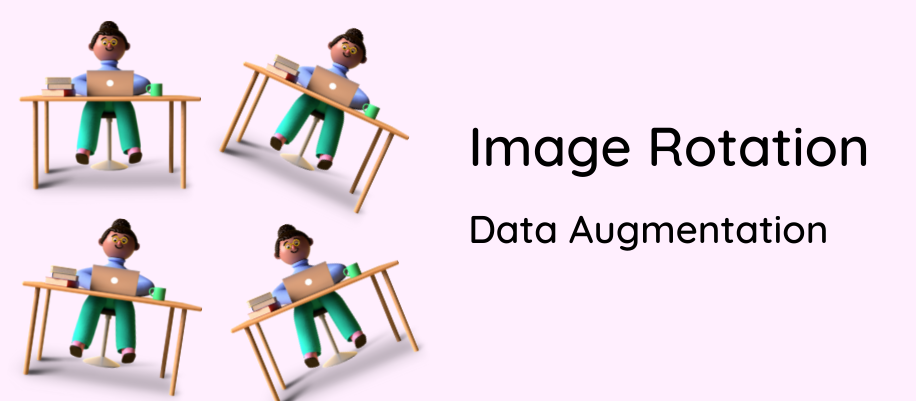

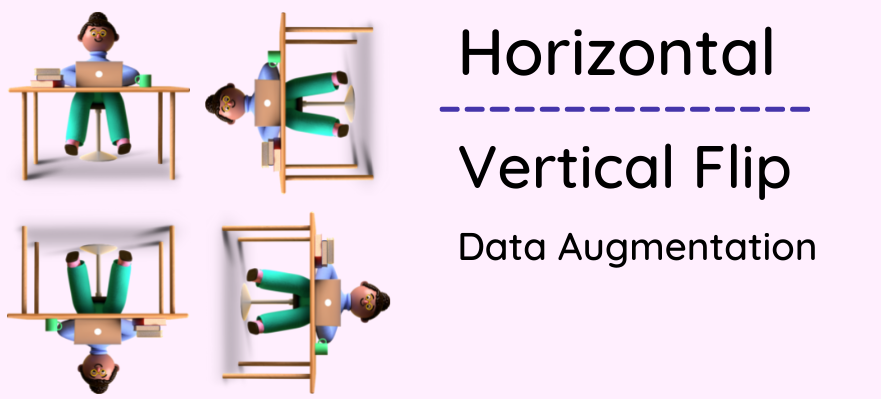

In [7]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['image']
        self.all_labels = np.array(self.csv.drop(['image', 'class'], axis=1))
        self.train_ratio = int(0.95 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        
        # set the training data images and labels
        if self.train == True and self.test == False:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomRotation(degrees=20),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
            ])
            
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
            
        # set the test data images
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names)
            self.labels = list(self.all_labels)
             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        if self.test == False:
            image = cv2.imread(f"{self.image_names[index]}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.transform(image)
            targets = self.labels[index]

            return {
                'image': torch.tensor(image, dtype=torch.float32),
                'label': torch.tensor(targets, dtype=torch.float32)
            }
        elif self.test == True:
            image = cv2.imread(f"../input/beyond-analysis/Test (1)/Test/{self.image_names[index]}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.transform(image)
            targets = self.labels[index]

            return {
                'image': torch.tensor(image, dtype=torch.float32),
                'label': torch.tensor(targets, dtype=torch.float32)
            }

## 📤 Model 📥

<p><b>VGG19 is a convolutional neural network architecture that is 19 layers deep. The main purpose for which the VGG net was designed was to win the ILSVRC imagenet competition.</b></p>

<div align = 'center'>
    <img src = 'https://qphs.fs.quoracdn.net/main-qimg-be5b8fe590952612479e45fe02b6bb35'>
</div>
<p>
    <h3>Brief look at the architecture of VGG19:</h3>

* <b>Input:</b> The VGG19 takes in an image input size of 224×224.
    
* <b>Convolutional Layers:</b> VGG’s convolutional layers leverage a minimal receptive field, i.e., 3×3, the smallest possible size that still captures up/down and left/right. This is followed by a ReLU activation function. ReLU stands for rectified linear unit activation function, it is a piecewise linear function that will output the input if positive otherwise, the output is zero. Stride is fixed at 1 pixel to keep the spatial resolution preserved after convolution.
    
* <b>Fully-Connected Layers:</b> The VGG19 has 3 fully connected layers. Out of the 3 layers, the first 2 have 4096 nodes each, and the third has 1000 nodes, which is the total number of classes the imagenet dataset has.
    </p>

In [8]:
def model(pretrained, requires_grad):
    model = models.vgg19(progress = True,pretrained = pretrained)
    
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
            
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

* Having less training data, we thought of using transfer learning and as we have previously worked with vgg19 we started with it. 
* We also used different models like vision transformer, vgg16, resnet50, but vgg19 showed the highest validation score.

### ♨ Function to unfreeze some layers

* We tried unfreezing some of the layers and unfreezing the last 2 worked best. 
* It makes sense since we have such less training data and the initial layers, trained on imagenet data are well set for general feature extraction.

In [9]:
def unfreeze(model):
    l = list(model._modules.keys())[-2:]
    print(f"unfreezing these layer {l}")
    for name in l:
        for params in model._modules[name].parameters():
            params.requires_grad_(True)

## 📏 Custom Metric 

<b>A score is generated for every data point in the test set based on the following rules:</b>

<b>1)</b> All predicted labels should be submitted for the data point. If the submitted labels is exactly equivalent to the true labels, 1 mark is given. If the submitted labels are a subset of true labels, partial marks are given. 

<b>2)</b> Average marks on all test data points are taken. This is the final metric on which ranking is generated. This value stays between 0 and 1.

In [10]:
def my_metric(ytrue,ypred):
    temp = np.argsort(ypred)[-1:][0]
    for i in range(len(ypred)):
        ypred[i] = 0
    ypred[temp] = 1
    true_1 = list(np.where(ytrue)[0])
    pred_1 = list(np.where(ypred)[0])
    false_1 = list(np.where([i-1 for i in ytrue])[0])
    count = 0
    for i in pred_1:
        if i in true_1:
            count+=1
    val = count/len(true_1)
    for i in false_1:
        if ypred[i]==1:
            val = 0
            break
    return val

## 📝 Training Function

<h3> Our thought Process:</h3>

*  We have a **multilabel classification problem**, a relatively uncommon problem.

* Usually when it comes to detecting multiple objects in an image, the approach is image segmentation or object detection but in this case it is neither of them since the images were not labeled that way.

* When we encounter a multi label classification problem, one might think it is similar to a multi class problem and go forward with the approach of using softmax as the activation layer but in this case that would not be useful as softmax function predicts the most probable label and ignores the other labels and this does not allow the selection of multiple labels.

* Thus, we used sigmoid as our activation function because it would allow us to find probabilities of each label and pick multiple labels for an image based on some threshold. We took **outputs from a linear layer with number of nodes = number of labels and applied sigmoid activation to each node to get the outputs.** Then we calculate loss by **Binary Cross Entropy loss** function.


In [11]:
def train(model, dataloader, optimizer, criterion, train_data, device,scheduler):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    accuracy = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        accuracy += my_metric(list(target.detach().cpu()[0].numpy()),list(outputs.detach().cpu()[0].numpy()))
    scheduler.step()
    train_loss = train_running_loss / counter
    accuracy = accuracy/counter
    return train_loss,accuracy

## ✅ Validation Function

In [12]:
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    accuracy = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
            accuracy += my_metric(list(target.detach().cpu()[0].numpy()),list(outputs.detach().cpu()[0].numpy()))
        val_loss = val_running_loss / counter
        accuracy = accuracy/counter
        return val_loss,accuracy

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#intialize the model
model = model(pretrained=True, requires_grad=False).to(device)
unfreeze(model)

# learning parameters
lr=1e-4
epochs = 15
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()
sgdr_partial = lr_scheduler.StepLR(optimizer,step_size = 6,gamma = 0.1)

train_data = ImageDataset(
    df, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    df, train=False, test=False
)

test_data = ImageDataset(
    df_test, train=False, test=True
)


# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_data, 
    batch_size=1,
    shuffle=False
)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

unfreezing these layer ['avgpool', 'classifier']
Number of training images: 2668
Number of validation images: 141


## 💱 Starting the training and validation

In [14]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss,accuracy_train = train(
        model, train_loader, optimizer, criterion, train_data, device,sgdr_partial
    )
    valid_epoch_loss,accuracy_val = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')
    print(f"Train Accuracy: {accuracy_train:.4f}")
    print(f'Val Accuracy: {accuracy_val:.4f}')

Epoch 1 of 15
Training


  0%|          | 0/83 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
84it [00:34,  2.44it/s]


Validating


5it [00:01,  3.87it/s]                       


Train Loss: 0.3389
Val Loss: 0.2125
Train Accuracy: 0.5024
Val Accuracy: 1.0000
Epoch 2 of 15
Training


84it [00:16,  5.04it/s]


Validating


5it [00:00,  6.43it/s]                       


Train Loss: 0.2188
Val Loss: 0.1325
Train Accuracy: 0.8135
Val Accuracy: 1.0000
Epoch 3 of 15
Training


84it [00:16,  4.96it/s]


Validating


5it [00:00,  6.98it/s]                       


Train Loss: 0.1683
Val Loss: 0.1063
Train Accuracy: 0.8611
Val Accuracy: 1.0000
Epoch 4 of 15
Training


84it [00:16,  4.96it/s]


Validating


5it [00:00,  6.76it/s]                       


Train Loss: 0.1270
Val Loss: 0.1069
Train Accuracy: 0.8270
Val Accuracy: 1.0000
Epoch 5 of 15
Training


84it [00:16,  4.97it/s]


Validating


5it [00:00,  6.67it/s]                       


Train Loss: 0.1098
Val Loss: 0.0569
Train Accuracy: 0.8738
Val Accuracy: 1.0000
Epoch 6 of 15
Training


84it [00:16,  4.99it/s]


Validating


5it [00:00,  6.98it/s]                       


Train Loss: 0.0862
Val Loss: 0.0495
Train Accuracy: 0.9040
Val Accuracy: 1.0000
Epoch 7 of 15
Training


84it [00:16,  4.96it/s]


Validating


5it [00:00,  6.94it/s]                       


Train Loss: 0.0665
Val Loss: 0.0400
Train Accuracy: 0.9528
Val Accuracy: 1.0000
Epoch 8 of 15
Training


84it [00:16,  4.98it/s]


Validating


5it [00:00,  6.89it/s]                       


Train Loss: 0.0590
Val Loss: 0.0375
Train Accuracy: 0.9409
Val Accuracy: 1.0000
Epoch 9 of 15
Training


84it [00:16,  5.01it/s]


Validating


5it [00:00,  7.03it/s]                       


Train Loss: 0.0607
Val Loss: 0.0346
Train Accuracy: 0.9544
Val Accuracy: 1.0000
Epoch 10 of 15
Training


84it [00:16,  4.95it/s]


Validating


5it [00:00,  6.83it/s]                       


Train Loss: 0.0549
Val Loss: 0.0330
Train Accuracy: 0.9125
Val Accuracy: 1.0000
Epoch 11 of 15
Training


84it [00:16,  5.00it/s]


Validating


5it [00:00,  6.75it/s]                       


Train Loss: 0.0560
Val Loss: 0.0326
Train Accuracy: 0.9617
Val Accuracy: 1.0000
Epoch 12 of 15
Training


84it [00:17,  4.91it/s]


Validating


5it [00:00,  6.83it/s]                       


Train Loss: 0.0509
Val Loss: 0.0306
Train Accuracy: 0.9397
Val Accuracy: 1.0000
Epoch 13 of 15
Training


84it [00:17,  4.92it/s]


Validating


5it [00:00,  6.82it/s]                       


Train Loss: 0.0498
Val Loss: 0.0301
Train Accuracy: 0.9210
Val Accuracy: 1.0000
Epoch 14 of 15
Training


84it [00:17,  4.92it/s]


Validating


5it [00:00,  7.00it/s]                       


Train Loss: 0.0483
Val Loss: 0.0302
Train Accuracy: 0.9484
Val Accuracy: 1.0000
Epoch 15 of 15
Training


84it [00:16,  4.98it/s]


Validating


5it [00:00,  6.33it/s]                       

Train Loss: 0.0465
Val Loss: 0.0299
Train Accuracy: 0.9313
Val Accuracy: 1.0000


## 📉 Loss Plots

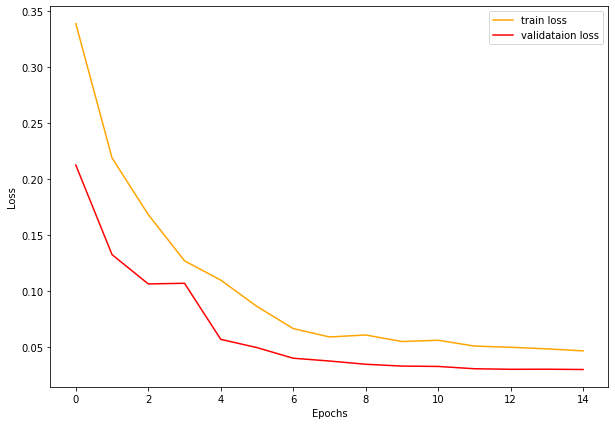

In [15]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

## 🤔 Inference

* For this particular problem, we were not able to set a proper threshold for the output function to identify multi labels as in most of the cases the model will predict high probabilities for multiple labels in selected scenarios and lower probabilities for some labels in some different scenarios.

* For eg : In case of head lamp damage, the output value of sigmoid activation for tail lamp damage is also high, because the model cannot easily distinguish between head and tail lamp, and in some other cases the sigmoid values were on the lesser side and were less than the threshold we set, thus making it impossible to set a common threshold for all labels.

* Hence, we simply selected a single label and for this case it gave good results

In [16]:
valid_loader = DataLoader(
    valid_data, 
    batch_size=1,
    shuffle=False
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


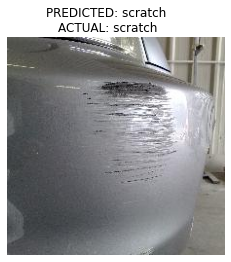

In [17]:
classes = df.columns.values[2:]
outputs_all = []
for counter, data in enumerate(valid_loader):
    image, target = data['image'].to(device), data['label']
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]
    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    outputs_all.append(outputs)
    outputs = outputs.detach().cpu()
    sorted_indices = np.argsort(outputs[0])
    best = sorted_indices[-1:]
    string_predicted = ''
    string_actual = ''
    for i in range(len(best)):
        string_predicted += f"{classes[best[i]]}     "
    for i in range(len(target_indices)):
        string_actual += f"{classes[target_indices[i]]}    "
    image = np.squeeze(image,axis = 0)
    image = image.detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    
plt.imshow(image)
plt.axis('off')
plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
plt.savefig(f"example_inference_{counter}.jpg")
plt.show()

In [18]:
test_loader = DataLoader(
    test_data, 
    batch_size=1,
    shuffle=False
)

In [19]:
classes = df.columns.values[2:]
outputs_all = []
predictions = []
image_names = []
for counter, data in enumerate(test_loader):
    image= data['image'].to(device)
    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    outputs_all.append(outputs)
    outputs = outputs.detach().cpu()
    sorted_indices = np.argsort(outputs[0])
    best = sorted_indices[-1:]
    image_names.append(data['image'])
    for i in range(len(best)):
        predictions.append(classes[best[i]])
    string_predicted = ''
    string_actual = ''
    for i in range(len(best)):
        string_predicted += f"{classes[best[i]]}     "
    image = np.squeeze(image,axis = 0)
    image = image.detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    
# UNCOMMENT to view predictions
#     plt.imshow(image)
#     plt.axis('off')
#     plt.title(f"PREDICTED: {string_predicted}")
#     plt.savefig(f"inference_{counter}.jpg")
#     plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## 📜 Submission

In [20]:
df_test['class'] = predictions
df_test.drop('test',axis = 'columns',inplace = True)

In [21]:
df_test.to_csv('beyond_analysis_submission_vgg19.csv',index = False)

In [22]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'model.h5')

## Further Improvements

* Talking about further improvements, we thought about the process of object detection using YOLO or detectron. These models would detect areas of damage in each vehicle. This detected region would then go through a CNN trained on damaged dataset to classify the type of damage. But due to lack of time, we were unable to implement it.

* Another way to implement multi label classification was to use one versus rest classification (eg: head_lamp broken vs not broken)  but this was something for which we didn't have the time to fully try and implement as we would have had to look at how we chose our samples for each binary classification problem.

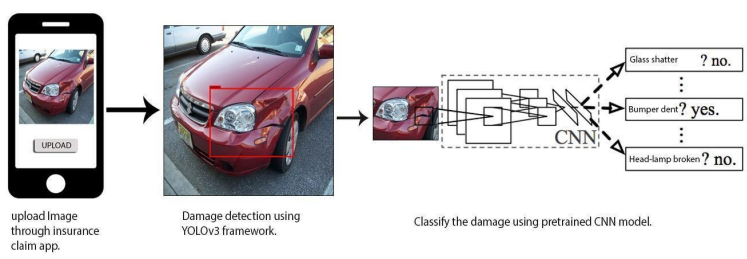